In [26]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [27]:
import importlib
import LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
import LearningCutsUtils.Utils as LCU
importlib.reload(LearningCutsUtils.Utils)
importlib.reload(LCU)

<module 'LearningCutsUtils.Utils' from '/home/mhance/NN-For-Cuts/LearningCutsUtils/Utils.py'>

In [28]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars
import LearningCutsUtils
importlib.reload(LearningCutsUtils)
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork

In [29]:
x=None
y=None

dummydata=False

if dummydata:
    x_signal, y_signal, x_backgr, y_backgr, branches = LCU.load_random_data()
else:
    x_signal, y_signal, x_backgr, y_backgr, branches = LCU.load_SUSY_data()
    

num_sig_events=len(y_signal)
num_bkg_events=len(y_backgr)

N=0 # number of points

if num_bkg_events>num_sig_events:
    x = np.concatenate((x_signal,x_backgr[:num_sig_events]))
    y = np.concatenate((y_signal,y_backgr[:num_sig_events]))
    N=2*num_bkg_events
else:
    x = np.concatenate((x_signal[:num_bkg_events],x_backgr))
    y = np.concatenate((y_signal[:num_bkg_events],y_backgr))
    N=2*num_sig_events
    
m=x_signal.shape[1]

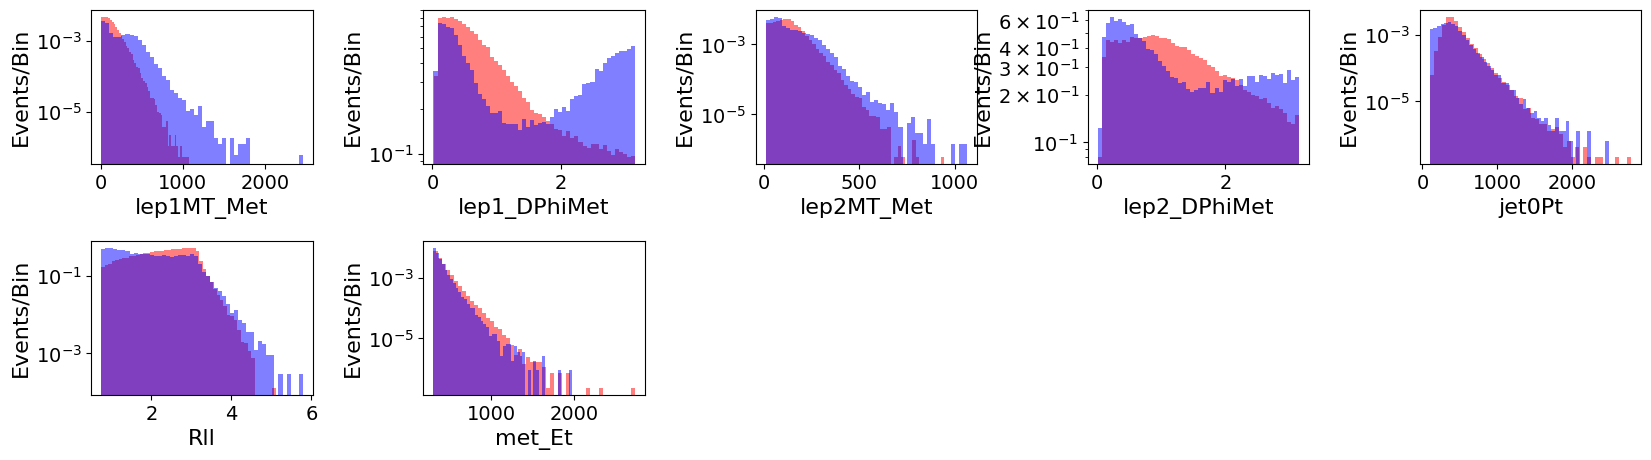

In [30]:
fig = plt.figure(figsize=(20,2.5*(int(m/5)+1)))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(int(m/5)+1,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"{branches[b]}")
    ax.set_ylabel("Events/Bin")
plt.savefig("features_dummy.pdf")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [32]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
print(len(y_train_tensor))

53259


In [33]:
gt=1.
lt=-1.
cuts_gt_lt = []
if m==10:
# default for a long time
#    cuts_gt_lt = [lt, gt, gt, gt, lt,
#                  gt, lt, lt, lt, gt]
# what a traditional network learns
    cuts_gt_lt = [lt, gt, gt, gt, gt,
                  gt, lt, gt, lt, gt]
elif m==5:
    cuts_gt_lt = [lt, lt, gt, gt, gt]
elif m==7:
    cuts_gt_lt = [lt, lt, gt, gt, gt,
                  gt, gt]
elif m==8:
    cuts_gt_lt = [lt, lt, lt, lt, lt,
                  gt, gt, gt]

Training a typical network yields weights that look like:

```
Parameter containing:
tensor([[-0.3928,  0.5802,  1.2111,  1.4545,  0.2581,
          0.5034, -0.7675,  0.0161, -2.2195,  0.6337]], requires_grad=True)
```

or

```
    cuts_gt_lt = [lt, gt, gt, gt, gt,
                  gt, lt, gt, lt, gt]
```

In [34]:
targeteffics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.95]

# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100

# how we scale the inputs to the activation function.
# larger values improve the matching of the signal efficiency
# calculated in the loss function and the efficiency that we
# see when applying the cuts.
activation_input_scale_factor=15

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
delta    = 1e-3  # scaling factor for how much to use BCE loss to optimize
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [35]:
torch.manual_seed(123)

efficnet = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(efficnet.state_dict(), 'net_learningbiases_effictarget_untrained.pth')
efficnet_optimizer = torch.optim.SGD(efficnet.parameters(), lr=learning_rate)

BCEnet = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(BCEnet.state_dict(), 'net_learningbiases_BCE_untrained.pth')
#BCEnet_optimizer = torch.optim.SGD(BCEnet.parameters(), lr=learning_rate)
BCEnet_optimizer = torch.optim.Adam(BCEnet.parameters(), lr=learning_rate)

onenet = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(onenet.state_dict(), 'net_learningbiases_oneeffic_untrained.pth')
onenet_optimizer = torch.optim.SGD(onenet.parameters(), lr=learning_rate)

In [36]:
efficnet_losses = []
efficnet_losses_test = []
BCEnet_losses = []
BCEnet_losses_test = []
onenet_losses = []
onenet_losses_test = []

efficnet.load_state_dict(torch.load('net_learningbiases_effictarget_untrained.pth',weights_only=True))
BCEnet.load_state_dict(torch.load('net_learningbiases_BCE_untrained.pth',weights_only=True))
onenet.load_state_dict(torch.load('net_learningbiases_oneeffic_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    efficnet.train()
    BCEnet.train()
    onenet.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred_efficnet = efficnet(x_batch)
        efficnet_optimizer.zero_grad()
        efficnet_loss = effic_loss_fn(y_pred_efficnet, y_batch, m, efficnet, alpha, beta, gamma, delta, epsilon,debug=debug)
        efficnet_loss.totalloss().backward()
        efficnet_optimizer.step()
        
        y_pred_BCEnet = BCEnet(x_batch)
        BCEnet_optimizer.zero_grad()
        BCEnet_loss = torch.nn.BCELoss()(y_pred_BCEnet, y_batch)
        BCEnet_loss.backward()
        BCEnet_optimizer.step()
        
        y_pred_onenet = onenet(x_batch)
        onenet_optimizer.zero_grad()
        onenet_loss = loss_fn(y_pred_onenet, y_batch, m, onenet, 0.93, alpha, beta, gamma, delta, debug=debug)
        onenet_loss.totalloss().backward()
        onenet_optimizer.step()
    
        #loss = ATLAS_significance_loss(y_pred, y_batch, reluncert=0.2)
        
    efficnet_losses.append(efficnet_loss)
    BCEnet_losses.append(BCEnet_loss.data)
    onenet_losses.append(onenet_loss)

    # configure the model for evaluation (testing)
    efficnet.eval() 
    BCEnet.eval()
    onenet.eval()
    
    y_pred_efficnet = efficnet(x_test_tensor)
    test_loss_efficnet = effic_loss_fn(y_pred_efficnet, y_test_tensor, m, efficnet, alpha, beta, gamma, delta, epsilon)
    efficnet_losses_test.append(test_loss_efficnet)
    
    y_pred_BCEnet = BCEnet(x_test_tensor)
    test_loss_BCEnet = torch.nn.BCELoss()(y_pred_BCEnet, y_test_tensor)
    BCEnet_losses_test.append(test_loss_BCEnet.data)
    
    y_pred_onenet = onenet(x_test_tensor)
    test_loss_onenet = loss_fn(y_pred_onenet, y_test_tensor, m, onenet, 0.93, alpha, beta, gamma, delta)
    onenet_losses_test.append(test_loss_onenet)
    
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, efficnet Train loss={efficnet_loss.totalloss().data:4.1e}, efficnet Test loss={test_loss_efficnet.totalloss().data:4.1e}, BCEnet Train loss={BCEnet_loss.data:4.1e}, BCEnet Test loss={test_loss_BCEnet.data:4.1e}") #, onenet Train loss={onenet_loss.totalloss().data:4.1e}, onenet Test loss={test_loss_onenet.totalloss().data:4.1e}  ")

torch.save(efficnet.state_dict(), 'net_learningbiases_effictarget_trained.pth')
torch.save(BCEnet.state_dict(), 'net_learningbiases_BCE_trained.pth')
torch.save(onenet.state_dict(), 'net_learningbiases_oneeffic_trained.pth')

Completed epoch  0 in  1.2s, efficnet Train loss=3.8e+01, efficnet Test loss=2.9e+01, BCEnet Train loss=1.5e+01, BCEnet Test loss=6.2e+00
Completed epoch  1 in  1.1s, efficnet Train loss=2.8e+01, efficnet Test loss=1.0e+01, BCEnet Train loss=6.3e+00, BCEnet Test loss=3.6e+00
Completed epoch  2 in  0.8s, efficnet Train loss=1.1e+01, efficnet Test loss=3.5e+00, BCEnet Train loss=3.7e+00, BCEnet Test loss=5.2e+00
Completed epoch  3 in  1.0s, efficnet Train loss=3.6e+00, efficnet Test loss=1.3e+00, BCEnet Train loss=5.2e+00, BCEnet Test loss=8.0e+00
Completed epoch  4 in  0.8s, efficnet Train loss=1.3e+00, efficnet Test loss=7.0e-01, BCEnet Train loss=7.8e+00, BCEnet Test loss=8.9e+00
Completed epoch  5 in  0.9s, efficnet Train loss=7.0e-01, efficnet Test loss=5.6e-01, BCEnet Train loss=8.7e+00, BCEnet Test loss=7.5e+00
Completed epoch  6 in  0.9s, efficnet Train loss=5.6e-01, efficnet Test loss=5.2e-01, BCEnet Train loss=7.4e+00, BCEnet Test loss=5.2e+00
Completed epoch  7 in  1.0s, effic

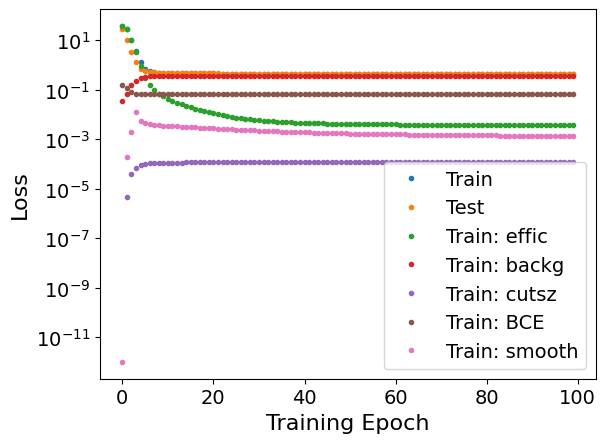

In [37]:
LCU.plotlosses(efficnet_losses,efficnet_losses_test)

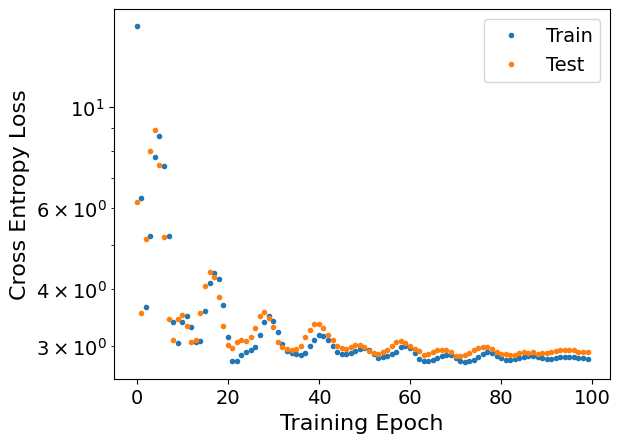

In [38]:
plt.plot(BCEnet_losses, '.', label="Train")
plt.plot(BCEnet_losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

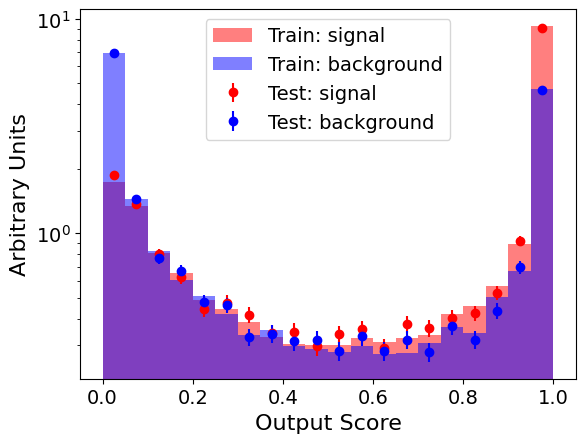

In [39]:
BCEnet.eval() # configure the model for evaluation (testing)
y_pred_test = BCEnet(x_test_tensor).detach().cpu()
y_pred_train= BCEnet(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_OTO_dummy.pdf")

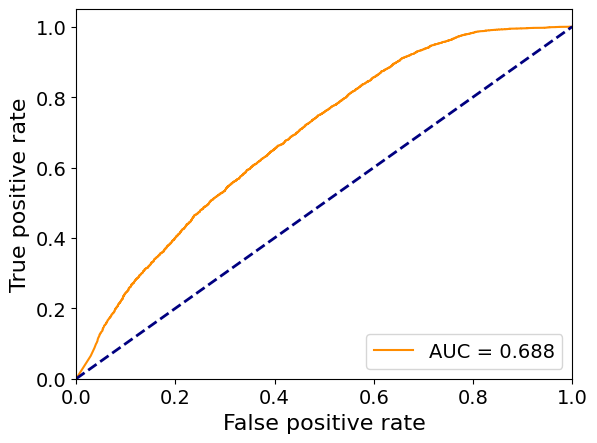

In [40]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_OTO_dummy.pdf")

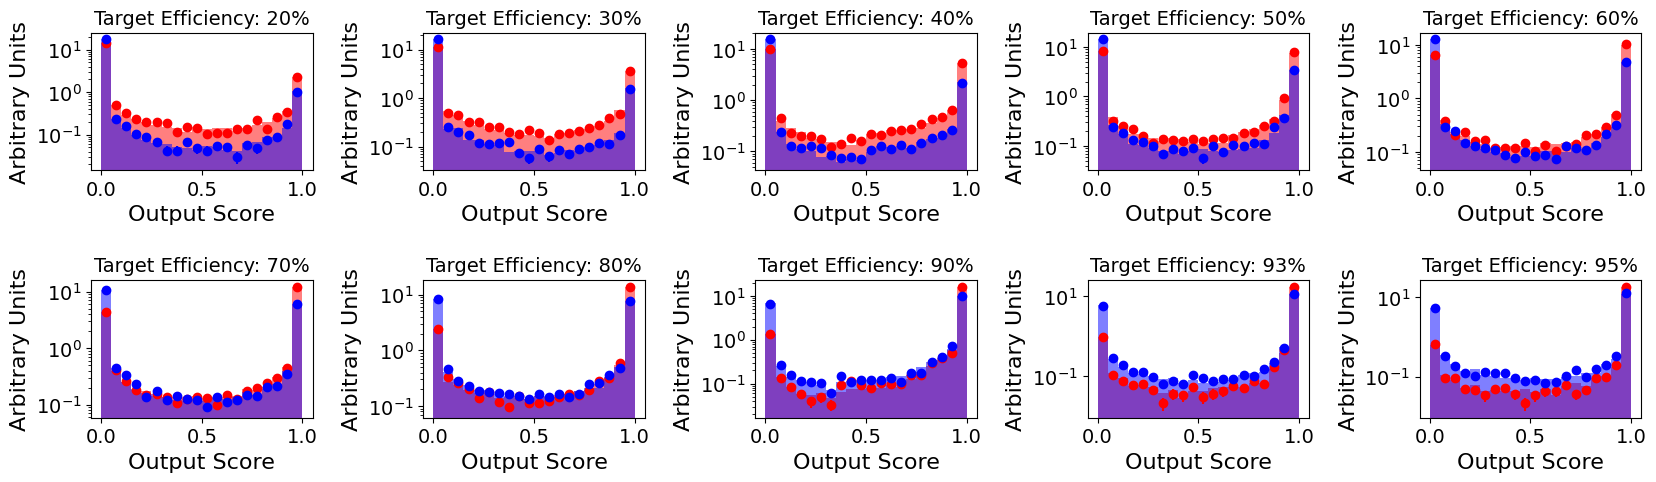

In [41]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)
    plt.yscale('log')

    efficnet.nets[n].eval()
    y_pred_test = efficnet.nets[n](x_test_tensor).detach().cpu()
    y_pred_train= efficnet.nets[n](x_train_tensor).detach().cpu()

    LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test)
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    showlegend=False
    if not showlegend:
        plt.legend('',frameon=False)
    else:
        ylim=plt.gca().get_ylim()
        plt.ylim([1e-3, 10000*ylim[1]])


plt.savefig("scores_efficscan_dummy.pdf")

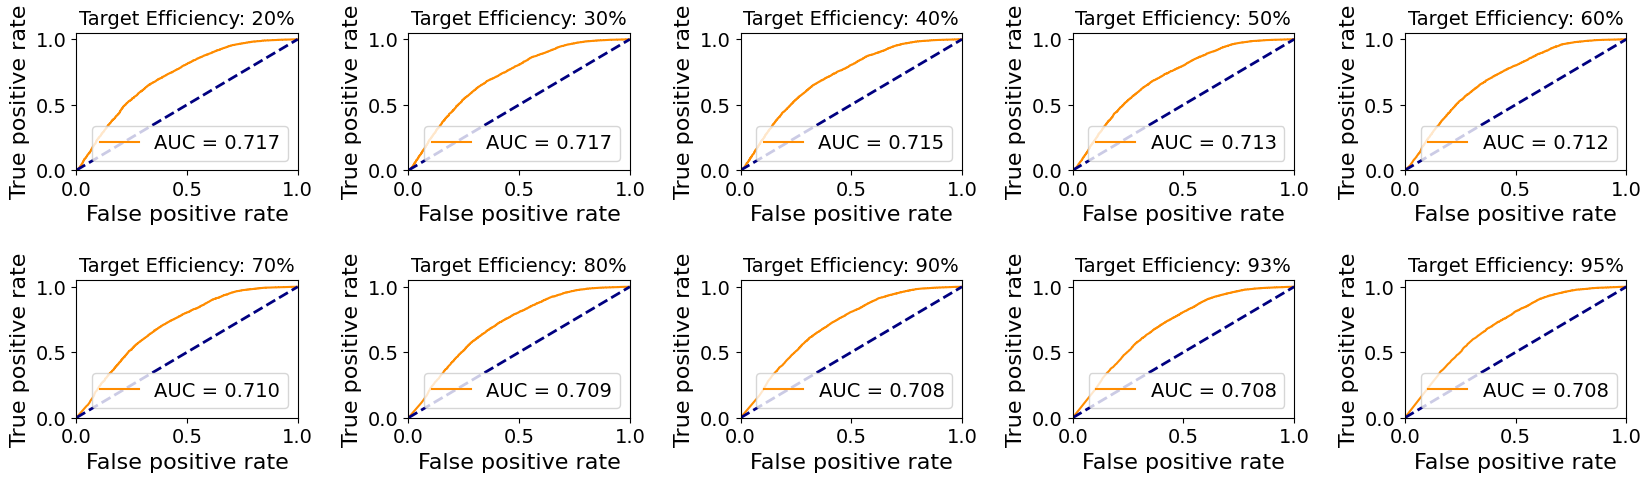

In [42]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)

    efficnet.nets[n].eval()
    y_pred_test = efficnet.nets[n](x_test_tensor).detach().cpu()
    #y_pred_train= efficnet.nets[n](x_train_tensor).detach().cpu()

    LCU.make_ROC_curve(y_test, y_pred_test)
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    
plt.savefig("ROC_efficscan_dummy.pdf")

Target efficiency: 20.0%
Signal     efficiency with net outputs: 20.4%
Background efficiency with net outputs:  8.33333%
BCE efficiency = 20.0, BCE background efficiency = 8.02027
Inspecting efficiency loss: alpha=10.0, target=0.200, subnet_effic=0.1978, subnet_backg=0.0832, efficloss=4.900e-05, backgloss=8.318e-03
------------
Target efficiency: 30.0%
Signal     efficiency with net outputs: 30.8%
Background efficiency with net outputs: 12.67144%
BCE efficiency = 29.9, BCE background efficiency = 13.22302
Inspecting efficiency loss: alpha=10.0, target=0.300, subnet_effic=0.2987, subnet_backg=0.1257, efficloss=1.744e-05, backgloss=1.257e-02
------------
Target efficiency: 40.0%
Signal     efficiency with net outputs: 43.3%
Background efficiency with net outputs: 18.66428%
BCE efficiency = 40.0, BCE background efficiency = 19.97615
Inspecting efficiency loss: alpha=10.0, target=0.400, subnet_effic=0.4029, subnet_backg=0.1754, efficloss=8.334e-05, backgloss=1.754e-02
------------
Target e

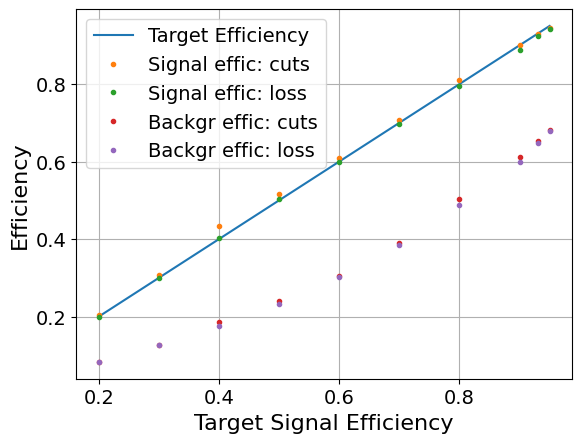

In [43]:
sig_effics=[]
bkg_effics=[]
loss_sig_effics=[]
loss_bkg_effics=[]

for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    sig_effic,bkg_effic=LCU.check_effic(x_test_tensor,y_test,efficnet.nets[n],True)
    sig_effics.append(sig_effic)
    bkg_effics.append(bkg_effic)
    
    # look at BCE network performance at similar efficiency
    y_pred_test = BCEnet(x_test_tensor).detach().cpu()
    fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
    for i in range(len(tpr)):
        if tpr[i]<targeteffics[n] and tpr[i+1]>targeteffics[n]:
            print(f"BCE efficiency = {tpr[i]*100:4.1f}, BCE background efficiency = {fpr[i]*100:6.5f}")
            break

    # check that after reloading the weights we still get the same performance after pretraining
    efficnet.nets[n].eval() # configure the model for evaluation (testing)
    y_pred_test = efficnet.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred_test, y_test_tensor, m, efficnet.nets[n], targeteffics[n], alpha, beta, gamma, delta, True)
    loss_sig_effics.append(test_loss.signaleffic.detach().numpy())
    loss_bkg_effics.append(test_loss.backgreffic.detach().numpy())
    print("------------")

plt.plot(targeteffics,targeteffics   , '-', label="Target Efficiency")
plt.plot(targeteffics,sig_effics     , '.', label="Signal effic: cuts")
plt.plot(targeteffics,loss_sig_effics, '.', label="Signal effic: loss")
plt.plot(targeteffics,bkg_effics     , '.', label="Backgr effic: cuts")
plt.plot(targeteffics,loss_bkg_effics, '.', label="Backgr effic: loss")
plt.legend()
plt.xlabel('Target Signal Efficiency')
plt.ylabel('Efficiency')
plt.grid()
plt.savefig("efficiencies_efficscan_dummy.pdf")

I guess the message from this study is that scanning the output score distribution when optimizing using BCE loss
gives very similar performance to fixing an efficiency and optimizing for background rejection.  At a given efficiency,
the FPR for BCE loss is very similar to the FPR for the corresponding efficiency-tuned net, maybe a bit lower or higher, but overall consistent.

One could ask, then, why go through all the efficnet stuff?  The point is that scanning the output score, which is a single number per event, does not allow us to extract cuts for all variables from the previous network layer.

So I think the point is that we don't expect either to be better or worse, and the efficnet performance is not obviously worse than "just" using BCE, and allows us to extract cuts.

Another question we can ask: what cuts do we get from the BCE-trained net, and what efficiency do they correspond to?

In [44]:
effic_test,bg_effic_test = LCU.check_effic(x_test_tensor,y_test,BCEnet,False)
LCU.check_effic(x_test_tensor,y_test,BCEnet,True)

Signal     efficiency with net outputs: 66.1%
Background efficiency with net outputs: 41.15981%


(0.6612683517481459, 0.41159809183065)

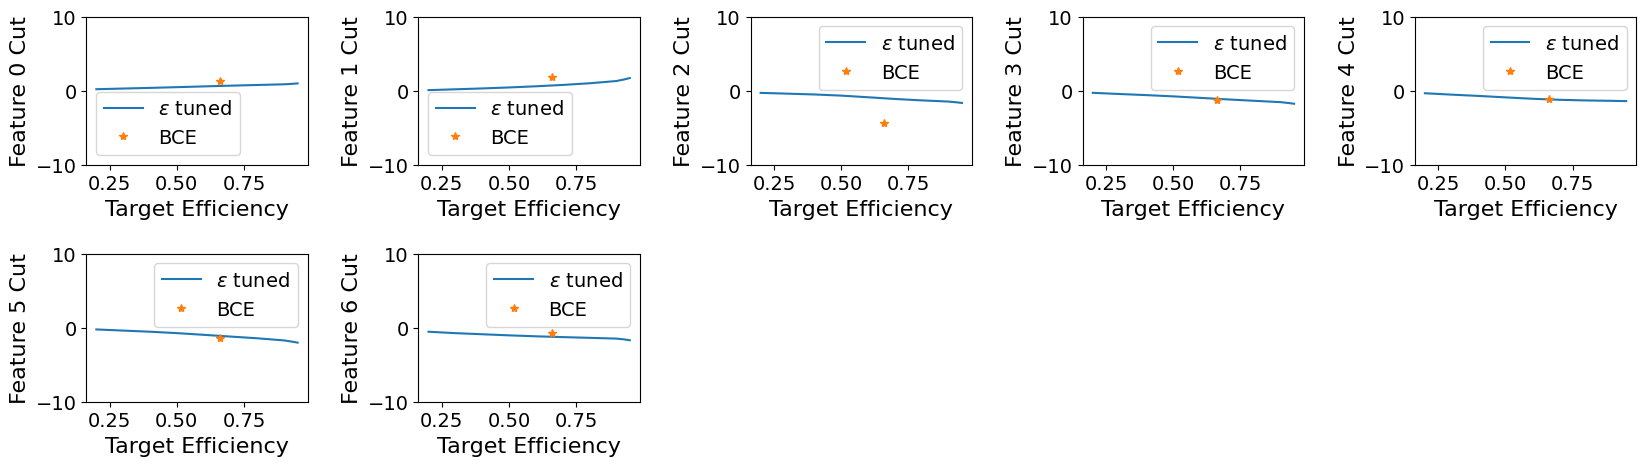

In [45]:
net=efficnet

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
targeteffics=net.effics
m=net.features

scaled_cuts=[len(targeteffics)*[0] for i in range(m)]
scaled_cuts_BCE=BCEnet.get_cuts().detach().numpy()
for n in range(len(targeteffics)):
    cuts=net.nets[n].get_cuts().detach().numpy()
    for f in range(m):
        cutval=cuts[f]
        scaled_cuts[f][n]=cutval
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,scaled_cuts[b],label="$\\varepsilon$ tuned")
    ax.plot(effic_test,scaled_cuts_BCE[b],"*",label="BCE")
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel(f"Feature {b} Cut")
    #ax.set_title(f"Feature {b}")
    ax.set_ylim([-10,10])
    plt.legend()

plt.savefig("cuts_efficscan_dummy.pdf")

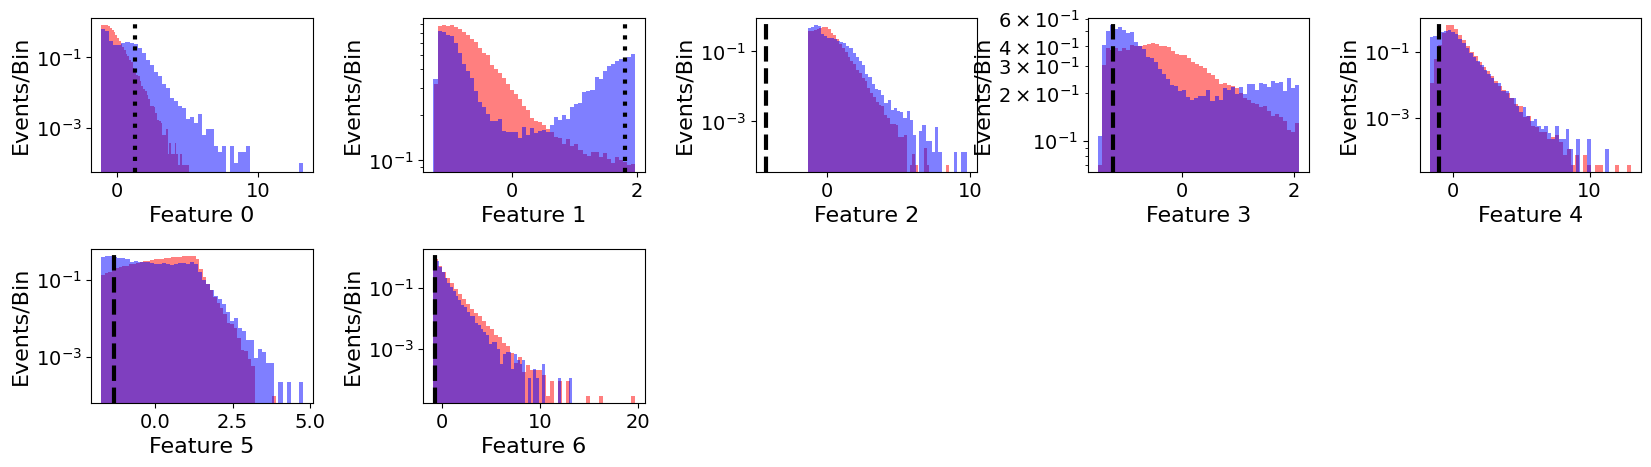

In [46]:
# Distributions after scaling for BCE-trained net:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

#biases=net.nets[n].bias.detach().numpy()
weights=BCEnet.weight.detach().numpy()
#scaled_cuts=-biases/weights
scaled_cuts=BCEnet.get_cuts().detach().numpy()

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], linestyle="dotted", color="black", lw=3) # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], linestyle="dashed", color="black", lw=3) # cut is "greater than"
plt.savefig("featurescuts_OTOBCE_dummy.pdf")

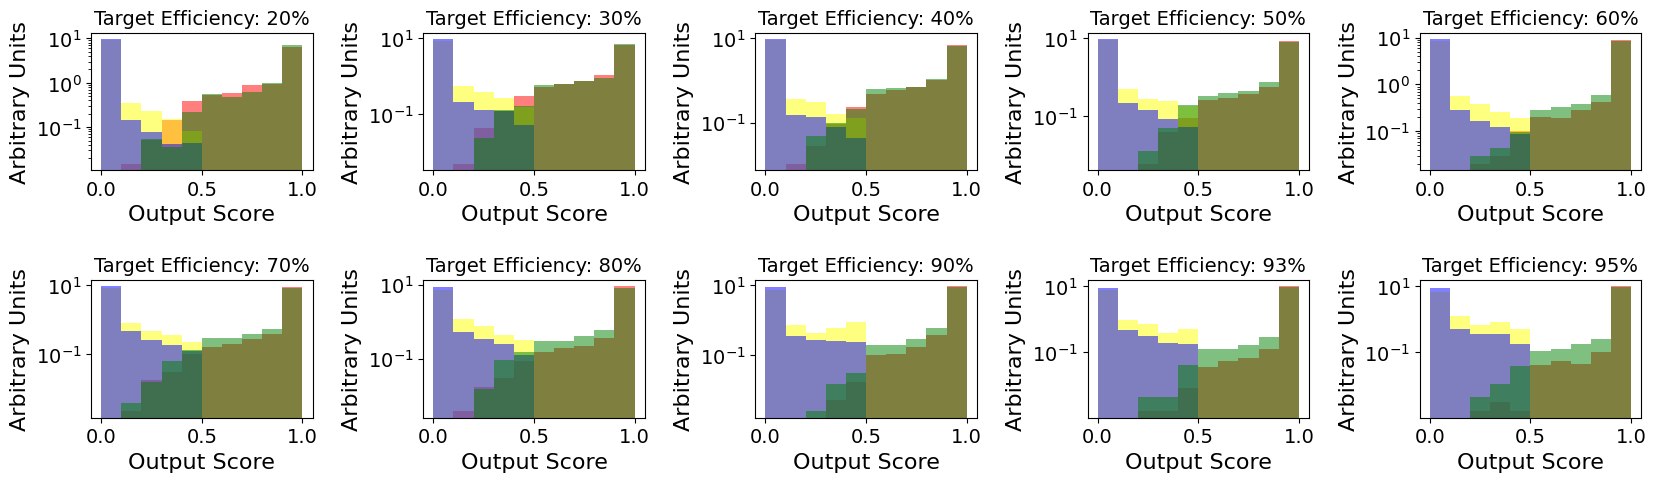

In [47]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)
    plt.yscale('log')

    efficnet.nets[n].eval()
    tp,tn,fp,fn = LCU.get_scores_by_label(x_test_tensor,y_test_tensor,efficnet.nets[n])
    LCU.plot_classifier_output_by_label(tp,fp,tn,fn)
    
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    showlegend=False
    if not showlegend:
        plt.legend('',frameon=False)
    else:
        ylim=plt.gca().get_ylim()
        plt.ylim([1e-3, 10000*ylim[1]])


plt.savefig("scoresbylabel_efficscan_dummy.pdf")

In [48]:
# plot the features after the cuts, to see what's left.

In [49]:
pass_mask = BCEnet.pass_cuts(x_test_tensor)
signal_mask   = y_test_tensor>0.5
backgr_mask   = y_test_tensor<0.5

print(pass_mask)
print(signal_mask)
signal_pass = torch.logical_and(signal_mask, pass_mask) 
backgr_pass = torch.logical_and(backgr_mask, pass_mask)

x_test_signal_pass = x_test_tensor[signal_pass]
x_test_backgr_pass = x_test_tensor[backgr_pass]

tensor([ True, False, False,  ...,  True,  True,  True])
tensor([ True,  True, False,  ..., False, False, False])


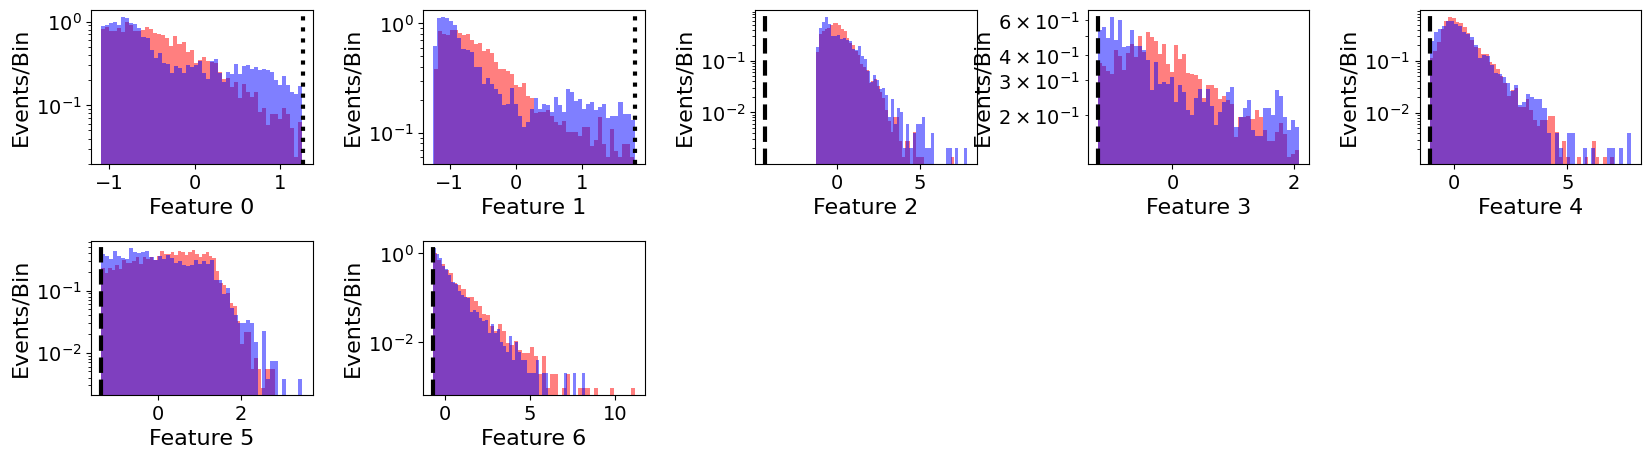

In [50]:
# Distributions after scaling for BCE-trained net:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

#biases=net.nets[n].bias.detach().numpy()
weights=BCEnet.weight.detach().numpy()
#scaled_cuts=-biases/weights
scaled_cuts=BCEnet.get_cuts().detach().numpy()

x_signal_scaled=x_test_signal_pass
x_backgr_scaled=x_test_backgr_pass

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], linestyle="dotted", color="black", lw=3) # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], linestyle="dashed", color="black", lw=3) # cut is "greater than"